In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import pickle

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.utils import to_categorical

MAX_WORDS_FOR_PREDICTION = 4
MAX_WORDS_TO_OUTPUT = 10

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Top_10000_Movies.csv to Top_10000_Movies.csv


In [ ]:
movies_data = pd.read_csv("Top_10000_Movies.csv")[:1000]
movies_data.tail()

,id,original_language,original_title,popularity,release_date,vote_average,vote_count,genre,overview,revenue,runtime,tagline
995,9902.0,en,Wrong Turn,59.786,2003-05-30,6.3,1901.0,"['Horror', 'Thriller']",Chris crashes into a carload of other young pe...,28650575.0,84.0,It's the last one you'll ever take.
996,460555.0,zh,红海行动,38.336,2018-02-16,6.8,143.0,"['Action', 'Thriller', 'War', 'Drama']",A squad of the Jiaolong Commando Unit - Sea Dr...,579220560.0,142.0,NaN
997,320288.0,en,Dark Phoenix,54.704,2019-06-05,6.0,4870.0,"['Science Fiction', 'Action', 'Adventure']",The X-Men face their most formidable and power...,252442974.0,114.0,The Phoenix will rise.
998,291805.0,en,Now You See Me 2,53.776,2016-06-02,6.8,9060.0,"['Thriller', 'Action', 'Comedy']",One year after outwitting the FBI and winning ...,334901337.0,129.0,You haven't seen anything yet.
999,23827.0,en,Paranormal Activity,57.510,2007-09-14,6.0,3939.0,"['Horror', 'Mystery']","After a young, middle-class couple moves into ...",194183034.0,86.0,What Happens When You Sleep?


In [ ]:
movie_names = movies_data["original_title"].astype(str).tolist()
movie_names[2]

'Dune'

In [ ]:
type(movie_names)

list

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(movie_names)
# saving the tokenizer for predict function
pickle.dump(tokenizer, open('token.pkl', 'wb'))
vocab_length = len(tokenizer.word_index) + 1

In [ ]:
X = []
y = []
max_sequence_len = 0
print("Unique words : ", vocab_length)
for name in movie_names:
  if len(name) > 1:
    tokens = tokenizer.texts_to_sequences([name])[0]
    tokens_length = len(tokens)
    if tokens_length > max_sequence_len:
      max_sequence_len = tokens_length

    for i in range(1, tokens_length):
      X.append(tokens[:i])
      y.append(tokens[i])

for i in range(10):
  print(X[i], y[i])

NameError: ignored

In [ ]:
X = np.array(pad_sequences(X, maxlen=max_sequence_len, padding='pre'))
print(len(X[1]))

11


In [ ]:
y = to_categorical(y, num_classes=vocab_length)
y[:5]



array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
print(max_sequence_len)

11


In [ ]:
type(X)

numpy.ndarray

In [ ]:
#make model
model = Sequential()
model.add(Embedding(vocab_length, 100, input_length=max_sequence_len))
model.add(Bidirectional(LSTM(1000)))
model.add(Dense(vocab_length, activation='softmax'))

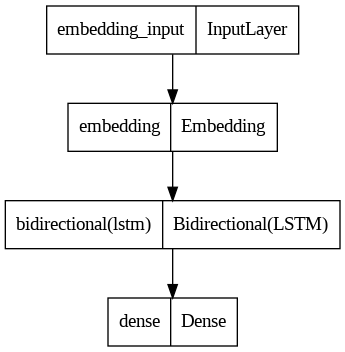

In [ ]:
from tensorflow import keras
from keras.utils.vis_utils import plot_model

plot_model(model, to_file="plot.png", show_layer_names=True)

In [ ]:
from keras.callbacks import ModelCheckpoint

checkpoint_file = "movie_names_model.h5"
checkpoint = ModelCheckpoint(checkpoint_file, monitor='loss', verbose=1, save_best_only=True)
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.fit(X, y, epochs=50, batch_size=2, callbacks=[checkpoint], verbose=1)

Epoch 1/50
976/980 [============================>.] - ETA: 0s - loss: 1.4483 - accuracy: 0.6562
Epoch 1: loss improved from inf to 1.44864, saving model to movie_names_model.h5
980/980 [==============================] - 16s 13ms/step - loss: 1.4486 - accuracy: 0.6554
Epoch 2/50
977/980 [============================>.] - ETA: 0s - loss: 0.9533 - accuracy: 0.7615
Epoch 2: loss improved from 1.44864 to 0.95269, saving model to movie_names_model.h5
980/980 [==============================] - 12s 13ms/step - loss: 0.9527 - accuracy: 0.7616
Epoch 3/50
977/980 [============================>.] - ETA: 0s - loss: 0.8322 - accuracy: 0.7886
Epoch 3: loss improved from 0.95269 to 0.83515, saving model to movie_names_model.h5
980/980 [==============================] - 13s 13ms/step - loss: 0.8351 - accuracy: 0.7882
Epoch 4/50
977/980 [============================>.] - ETA: 0s - loss: 0.7829 - accuracy: 0.7912
Epoch 4: loss improved from 0.83515 to 0.78099, saving model to movie_names_model.h5
980/980

In [ ]:
from keras.models import load_model
import numpy as np
import pickle

# Load the model and tokenizer
model = load_model('movie_names_model.h5')
tokenizer = pickle.load(open('token.pkl', 'rb'))

In [ ]:
def predict_movie(model, tokenizer, text):
  sequence = tokenizer.texts_to_sequences([text])
  sequence = np.array(sequence)
  preds = np.argmax(model.predict(sequence, verbose=0))
  for key, value in tokenizer.word_index.items():
      if value == preds:
        predicted_word = key
  return predicted_word

In [ ]:
text = "venom let there"

print(text, end=' ')
for i in range(MAX_WORDS_FOR_PREDICTION):
  next_word = predict_movie(model, tokenizer, text)
  if next_word in text:
    break
  text = text + " " + next_word
  print(next_word, end = ' ')

venom let there be carnage king of 